In [18]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


In [19]:
#read data

with open('data.csv', newline='') as csvfile:
    trainingdata = csv.reader(csvfile, delimiter=',')
    
    i=0
    copydata=[]
    Act={1:[],2:[],3:[],4:[],5:[],6:[]}
    Eneg=[]
    Col=[]
    for row in trainingdata:
        
        if i>0:
            copydata.append(row)
        if i==0:
            Col=row
            Eneg=row[6:]
            print(Col)
            
        if 0<i<28:
            Act[int(row[1])].append(row[2])    
        i = i+1
    


['Indnum', 'Group', 'Activity', 'Units', 'Consumption', 'Quality_of_Life_Importance__1_10', 'solar_powered__water_heater', 'gas_water_heater', 'electric_water_heater___peak_hours', 'electric_water_heater___off_peak hours', 'gas', 'natural_gas', 'hybrid', 'electric___peak_hours', 'electric___off_peak_hours', 'Jet Fuel']


In [20]:
#get rid of symbol of text
def clear_text(string):
    tmp=string.split('_')
    tmp=' '.join(tmp)
    tmp=tmp.split('-')
    tmp=' '.join(tmp)
    tmp=tmp.split('   ')
    tmp=' '.join(tmp)
    return tmp


In [21]:
#read carb map
carb_map,acts,cols=[],[],[]

with open('carb.csv', newline='') as csvfile: 
    carbdata = csv.reader(csvfile, delimiter=',')
    i=0
    for row in carbdata:
        if i==0:
            cols=[clear_text(x) for x in row]
        else:
            carb_map.append(row)
            acts.append(row[0])
        i+=1
print(cols)
print(acts)
#carb_map=np.asarray(carb_map)
#print(np.argmax([max(x[2:]) for x in carb_map]))
#print (carb_map[22][0])
            

['Activity', 'Per', 'solar powered  water heater', 'gas water heater', 'electric water heater peak hours', 'electric water heater off peak hours', 'gas', 'natural gas', 'Jet Fuel', 'waste management', 'hybrid', 'electric peak hours', 'electric off peak hours']
['Household heating => 70F', 'Household heating < 70F', 'Use of heat pump', 'Use of air conditioner', 'shower - short', 'shower - long (> 3 min)', 'bath', 'wash-up', 'use of dishwasher', 'use of clothes washer', 'use of clothes dryer', 'use of cooking range', 'use of  oven', 'use of self-clean feature of electric oven', 'Small kitchen appliance in the home', 'TV/computer use', 'air travel - large plane', 'air travel - small  plane (<50 seats)', 'car trips- self only', 'car trips - driver and self', 'car trips - 2+ people with multiple end points', 'trips using public ground transportation', 'bags of garbage disposed', 'bags of recycling deposited (negative CF)', 'bags of compost deposited (negative CF)', 'hazardous or electric it

In [22]:
#function to account personal carbon
def to_int(string):
    return 0 if string=='' else abs(int(string))

def carb_cnt(act,eneg,unit):
    eneg=clear_text(eneg)
    #carb_per_unit = carb_map[acts.index(act)][cols.index(eneg)]
    carb_per_unit = max(carb_map[acts.index(act)][2:])
    
    return 0 if carb_per_unit=='' else float(carb_per_unit)*unit
    

#carb_map[0].index(natural_gas)

In [23]:


def carb_plot(carbs):
    x=[i for i in range(len(carbs))]
    y=sorted(carbs)

    
    plt.plot(x,y,color='green')#,tick_label=acts[:,0])
    
    

In [24]:
#def normalize(people)
from sklearn.preprocessing import normalize

def normal(people):
    norm_people=np.copy(people)
    units=[row[1] for row in norm_people]
    norm_units=normalize(units,axis=0,norm='max')
 
    
    for i,x in enumerate(norm_units):
        norm_people[i][1]=x

    return norm_people
    
    
    

[50.63932999999999 46.204423999999996] 36.856767


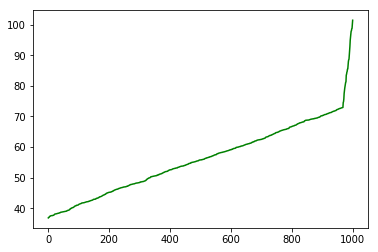

In [25]:
# conclude features for each person

newdata,importance,units,carbs,carb=[],[],[],[],0

for i,row in enumerate(copydata):
    if i%27== 0:
        newdata.append([importance,units,carbs,carb])
        
        importance=[]
        units=[]
        carbs=[]
        carb=0
    
    importance.append(to_int(row[5]))
    units.append(to_int(row[4]))
    act,eneg,unit=row[2],Eneg[np.argmax(row[6:])],to_int(row[4])
    carbs.append(carb_cnt(act,eneg,unit))
    carb=sum(carbs)
people=np.asarray(newdata[1:])

print(people[0:2,3],min(people[:,3]))
carb_plot(people[:,3])

norm_people=normal(people)


In [26]:
from math import log,sqrt 

def softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum() 
    
def to_fuc(x,fuc):
    if fuc=='log': return log(1+x)
    if fuc=='root': return sqrt(x)
    if fuc=='tanh': return np.tanh(x)
    if fuc=='linear': return float(x)
    if fuc=='softmax': return softmax(x)
    

In [27]:
#pick for the neighbors which spend least carbons    
def get_recommend(indice,people,fuc):
    recommend=[]
    
    for i,person in enumerate(indice):
        candidates= np.asarray([people[neigh] for neigh in person])
        
        carb=people[i][3]
        cand=np.argmin(candidates[:,3])
        cand_carb=candidates[cand][3]
        reduce=cand_carb/carb
        
        I,U=people[i][:2]
        cand_I,cand_U=candidates[cand][:2]
        adjusted_I=adjust_I(I,cand_I)
        
        happy,new_happy=Happy(I,fuc,U,i),Happy(adjusted_I,fuc,cand_U,i)
        loss=new_happy/happy
        recommend.append([i,cand,carb,cand_carb,reduce,loss])
        
    recommend=np.asarray(recommend)
    #print(recommend[:5])
    return recommend

In [28]:
def Happy(I,fuc,U,i):
    return sum([I[i]*to_fuc(U[i],fuc) for i in range(len(I)) if U[i]>0])
def adjust_I(I,cand_I):
    
    return [I[i] if I[i]>0 else cand_I[i] for i in range(len(I)) ]

#adjust_I([2,3,4,0,1,2,0],[9,9,9,9,9,9,9])
    

In [29]:
def performance(recom):
    happiness=sum(recom[:,-1])/len(recom)
    carb_utage=sum(recom[:,-2])/len(recom)
    print('happiness: {percent:.2%}'.format(percent=happiness),
          'carb utage: {percent:.2%}'.format(percent=carb_utage))


In [30]:
from sklearn.neighbors import NearestNeighbors
def get_neighs(k,people):

    Impor = [row[0] for row in people]
    Unit =  [row[1] for row in people]
    Impor_Unit = [row[0]+row[1] for row in people]

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(Impor[:])
    distances, I_indice = nbrs.kneighbors(Impor[:])
    #matric = nbrs.kneighbors_graph(X).toarray()

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(Unit[:])
    distances, U_indice = nbrs.kneighbors(Unit[:])
    
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(Impor_Unit[:])
    distances, IU_indice = nbrs.kneighbors(Impor_Unit[:])
    return I_indice,U_indice,IU_indice




In [31]:
def report(k,fuc):
    for i,indice in enumerate(get_neighs(k,people)):
        
        recom=get_recommend(indice,norm_people,fuc)
        performance(recom)
        
        if i==0 :new_life_plot(recom) #report the recomender generated by importance_
            
    print('----Evaluate utility by',fuc,'\n',
      '(Recommend behavior adjustion from',k,'neighbors using features\n'
      'Importance, Units, Importance_and_Units, respectively)\n')



In [32]:
from collections import Counter,OrderedDict
def new_life_plot(recom):
    plt.rcParams['figure.figsize'] = [8, 4]
    happy=recom[:,-1]
    happiness= [int(100*x) for x in happy]
    
    h=Counter((x) for x in happiness)
    h=OrderedDict(sorted(h.items()))
    plt.plot(h.keys(),h.values())
    
    carb=recom[:,-2]
    carbon= [int(100*x) for x in carb]
    
    c=Counter((x) for x in carbon)
    c=OrderedDict(sorted(c.items()))
    plt.plot(c.keys(),c.values(),'c',10)

happiness: 98.88% carb utage: 76.03%
happiness: 100.44% carb utage: 98.50%
happiness: 100.31% carb utage: 98.49%
----Evaluate utility by linear 
 (Recommend behavior adjustion from 10 neighbors using features
Importance, Units, Importance_and_Units, respectively)

happiness: 99.92% carb utage: 76.03%
happiness: 100.17% carb utage: 98.50%
happiness: 100.13% carb utage: 98.49%
----Evaluate utility by softmax 
 (Recommend behavior adjustion from 10 neighbors using features
Importance, Units, Importance_and_Units, respectively)

happiness: 99.04% carb utage: 76.03%
happiness: 100.46% carb utage: 98.50%
happiness: 100.35% carb utage: 98.49%
----Evaluate utility by log 
 (Recommend behavior adjustion from 10 neighbors using features
Importance, Units, Importance_and_Units, respectively)

happiness: 99.26% carb utage: 76.03%
happiness: 100.30% carb utage: 98.50%
happiness: 100.20% carb utage: 98.49%
----Evaluate utility by root 
 (Recommend behavior adjustion from 10 neighbors using features


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

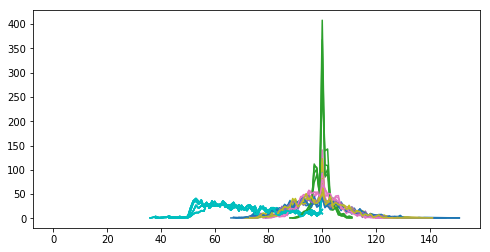

In [33]:
K=[10,20,50,100]
fucs=['linear','softmax','log','root','tanh']
[report(k,fuc) for k in K for fuc in fucs]
#K=[10]
#fucs=['softmax','linear']
#report(10,'softmax')


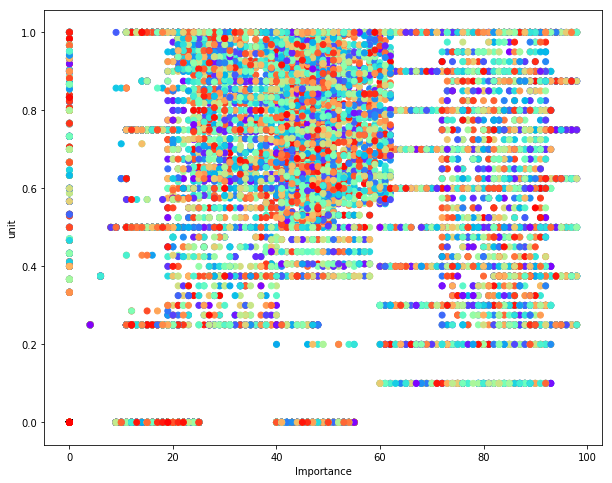

In [34]:
import matplotlib
def Importance_Unit(people):

    colors = matplotlib.cm.rainbow(np.linspace(0, 1, 1006)) 
    

    cs = [colors[i] for i in range(len(people))]

    xdata = [x for x in people[:,0]]
    ydata = [y for y in people[:,1]]
    
    
    plt.rcParams['figure.figsize'] = [10, 8]
    plt.scatter(xdata,ydata,color=cs)

    plt.xlabel('Importance')
    plt.ylabel('unit')
    #plt.title()
    
    plt.show()
    

Importance_Unit(norm_people)
    